<a href="https://colab.research.google.com/github/Yunkoo-GIT/Programming/blob/main/20210520_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


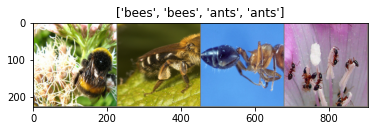

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.6281 Acc: 0.6721
val Loss: 0.3141 Acc: 0.8627

Epoch 1/24
----------
train Loss: 0.4317 Acc: 0.8115
val Loss: 0.2337 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.5492 Acc: 0.7787
val Loss: 0.4999 Acc: 0.8431

Epoch 3/24
----------
train Loss: 0.4599 Acc: 0.8074
val Loss: 0.2414 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.5661 Acc: 0.7828
val Loss: 0.1809 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.5599 Acc: 0.7951
val Loss: 0.3517 Acc: 0.8693

Epoch 6/24
----------
train Loss: 0.2480 Acc: 0.8852
val Loss: 0.2042 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.3512 Acc: 0.8525
val Loss: 0.2009 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.2730 Acc: 0.8852
val Loss: 0.1960 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.2147 Acc: 0.9016
val Loss: 0.1809 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.2193 Acc: 0.9057
val Loss: 0.1957 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.2004 Acc: 0.9016
val Loss: 0.1759 Acc: 0.9346

Epoch 12/24
----------
t

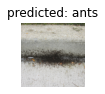

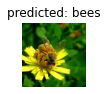

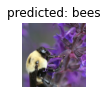

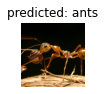

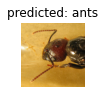

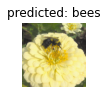

In [7]:
%matplotlib inline
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from  torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
plt.ion()  #interactive mode

from google.colab import drive
drive.mount('/content/gdrive')

data_transforms = {
    'train':transforms.Compose([
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
                               transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/gdrive/MyDrive/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True,
                                              num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc=0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    for phase in ['train', 'val']:
      if phase == 'train':
        scheduler.step()
        model.train()
      else:
        model.eval()
      running_loss = 0.0
      running_corrects = 0
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)
          if phase == 'train':
            loss.backward()
            optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))
  model.load_state_dict(best_model_wts)
  return model

def visualize_model(model, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('predicted: {}'.format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode=was_training)
          return
    model.train(mode=was_training)

model_ft = models.resnet18(pretrained=True)  #사전 학습된 ResNet18 가져오기
num_ftrs = model_ft.fc.in_features  #모델에서 feature extraction 후 FC 층에 입력되는 특징수
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)  # cpu나 GPU에 model_ft를 할당
criterion = nn.CrossEntropyLoss()

#모든 파라미터를 학습
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

#매 7 에포크 마다 학습율 0.1배 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

visualize_model(model_ft)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.6163 Acc: 0.6598
val Loss: 0.2092 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.3994 Acc: 0.7992
val Loss: 0.3870 Acc: 0.8301

Epoch 2/24
----------
train Loss: 0.4675 Acc: 0.7828
val Loss: 0.2396 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.5314 Acc: 0.7705
val Loss: 0.2973 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.5407 Acc: 0.7828
val Loss: 0.2787 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.4197 Acc: 0.8238
val Loss: 0.3522 Acc: 0.8562

Epoch 6/24
----------
train Loss: 0.4470 Acc: 0.8115
val Loss: 0.1797 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3459 Acc: 0.8689
val Loss: 0.1860 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3998 Acc: 0.8279
val Loss: 0.2291 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3241 Acc: 0.8525
val Loss: 0.2123 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3978 Acc: 0.8197
val Loss: 0.1998 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3492 Acc: 0.8443
val Loss: 0.1976 Acc: 0.9412

Epoch 12/24
----------
t

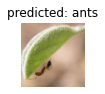

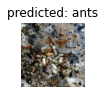

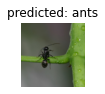

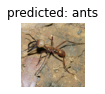

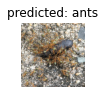

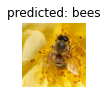

In [8]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
  param.requires_grad = False  #사전 학습된 모델의 가중치를 상수로 고정. 학습시키지 않음

#새로 생성된 모듈의 파라미터는 기본적으로 requires_grad=True
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

#마지막 층의 파라미터만 학습
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

visualize_model(model_conv)

plt.ioff()
plt.show()